# Figure notebook

Unreported boards (BibTex key, board, reason to not report)

- martinsRealtimeSVMbasedHardware2024, Cyclone V, "embedded system with an ARM Cortex-A9 integrated with Cyclone V SoC" + they get worse performance
- rapuanoFPGAbasedHardwareAccelerator2021a, Kintex US rad-hard (XQRKU060), don't report total power + half the frequency and double the latency + They use ZU7EV as a development board
- heConfigurable2D3D2023a, Zynq 7000 (Z7020) {Zedboard}, only ran HybridSN on it + lower-cost and less resources
- gargAircraftDetectionSatellite2024, Kintex Ultrascale(KU040), 0 details about it, just report lower FPS than the Zynq US+
- sabogalMethodologyEvaluatingAnalyzing2021a, Zynq Z7020, experiment same than their Zynq US+, no more details


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from utils.metadata import fpga_part_info, plot_colors
from utils.utils import support_labels
from pathlib import Path
import pandas as pd

pickleName = "all_datapoints.pkl"
datapointsDfPath = Path("..") / "data" / "Dataframes" / pickleName
datapointsDf = pd.read_pickle(datapointsDfPath)

versionTag = "_v4"
figureName = "fpga_board" + versionTag
saveFormat = "pdf"
saveFigurePath = Path("..") / "data" / "Figures" / "RQ_figures" / f"{figureName}.{saveFormat}"

In [2]:
# ----- Manually add the unreported FPGAs, available through the Tag "Other: (Unreported board): <family/serie>") -----
# Cyclone 5, Kintex US rad hard , Zynq 7000, Kintex US (KU040) , Z-7
unreportedFPGAS = ["5CSEMA5F31C6", "XQRKU060" , "XC7Z020","XCKU040","XC7Z020"]
# print(fpga_part_info)
# print(plot_colors)

def get_part(board_str):
    tag =  board_str.split("(")[0]
    board = board_str.split("{")[1].split("}")[0]
    part = board_str.split("(")[1].split(")")[0]
    if(board.endswith("KV260")):
        part = "XCK26"
    return part, board

# ----- Build a dictionary with the parts and their quantities -----
def add_part(parts, p):
    if p not in fpga_part_info:
        print(f"Warning: {p} not found in fpga_part_info")
        return
    if p in parts.keys():
        parts[p]["quantity"] += 1
    else:
        parts[p] = {}
        parts[p]["quantity"] = 1
        parts[p]["year"]    = fpga_part_info[p][0]
        parts[p]["DSP"]     = fpga_part_info[p][1]
        parts[p]["family"]  = fpga_part_info[p][2]

parts_info = {}
# For all article (i.e., unique experiment)
for part_name in datapointsDf["BBT Citation Key"].unique():
    df = datapointsDf[datapointsDf["BBT Citation Key"] == part_name]
    for board in df["Board"].unique():
        p, b = get_part(board)
        add_part(parts_info, p)
# And for the unreported FPGAs
for p in unreportedFPGAS:
    add_part(parts_info, p)
parts_info = {part_name: info for part_name, info in sorted(parts_info.items(), key=lambda item: item[1]["quantity"], reverse=True)}

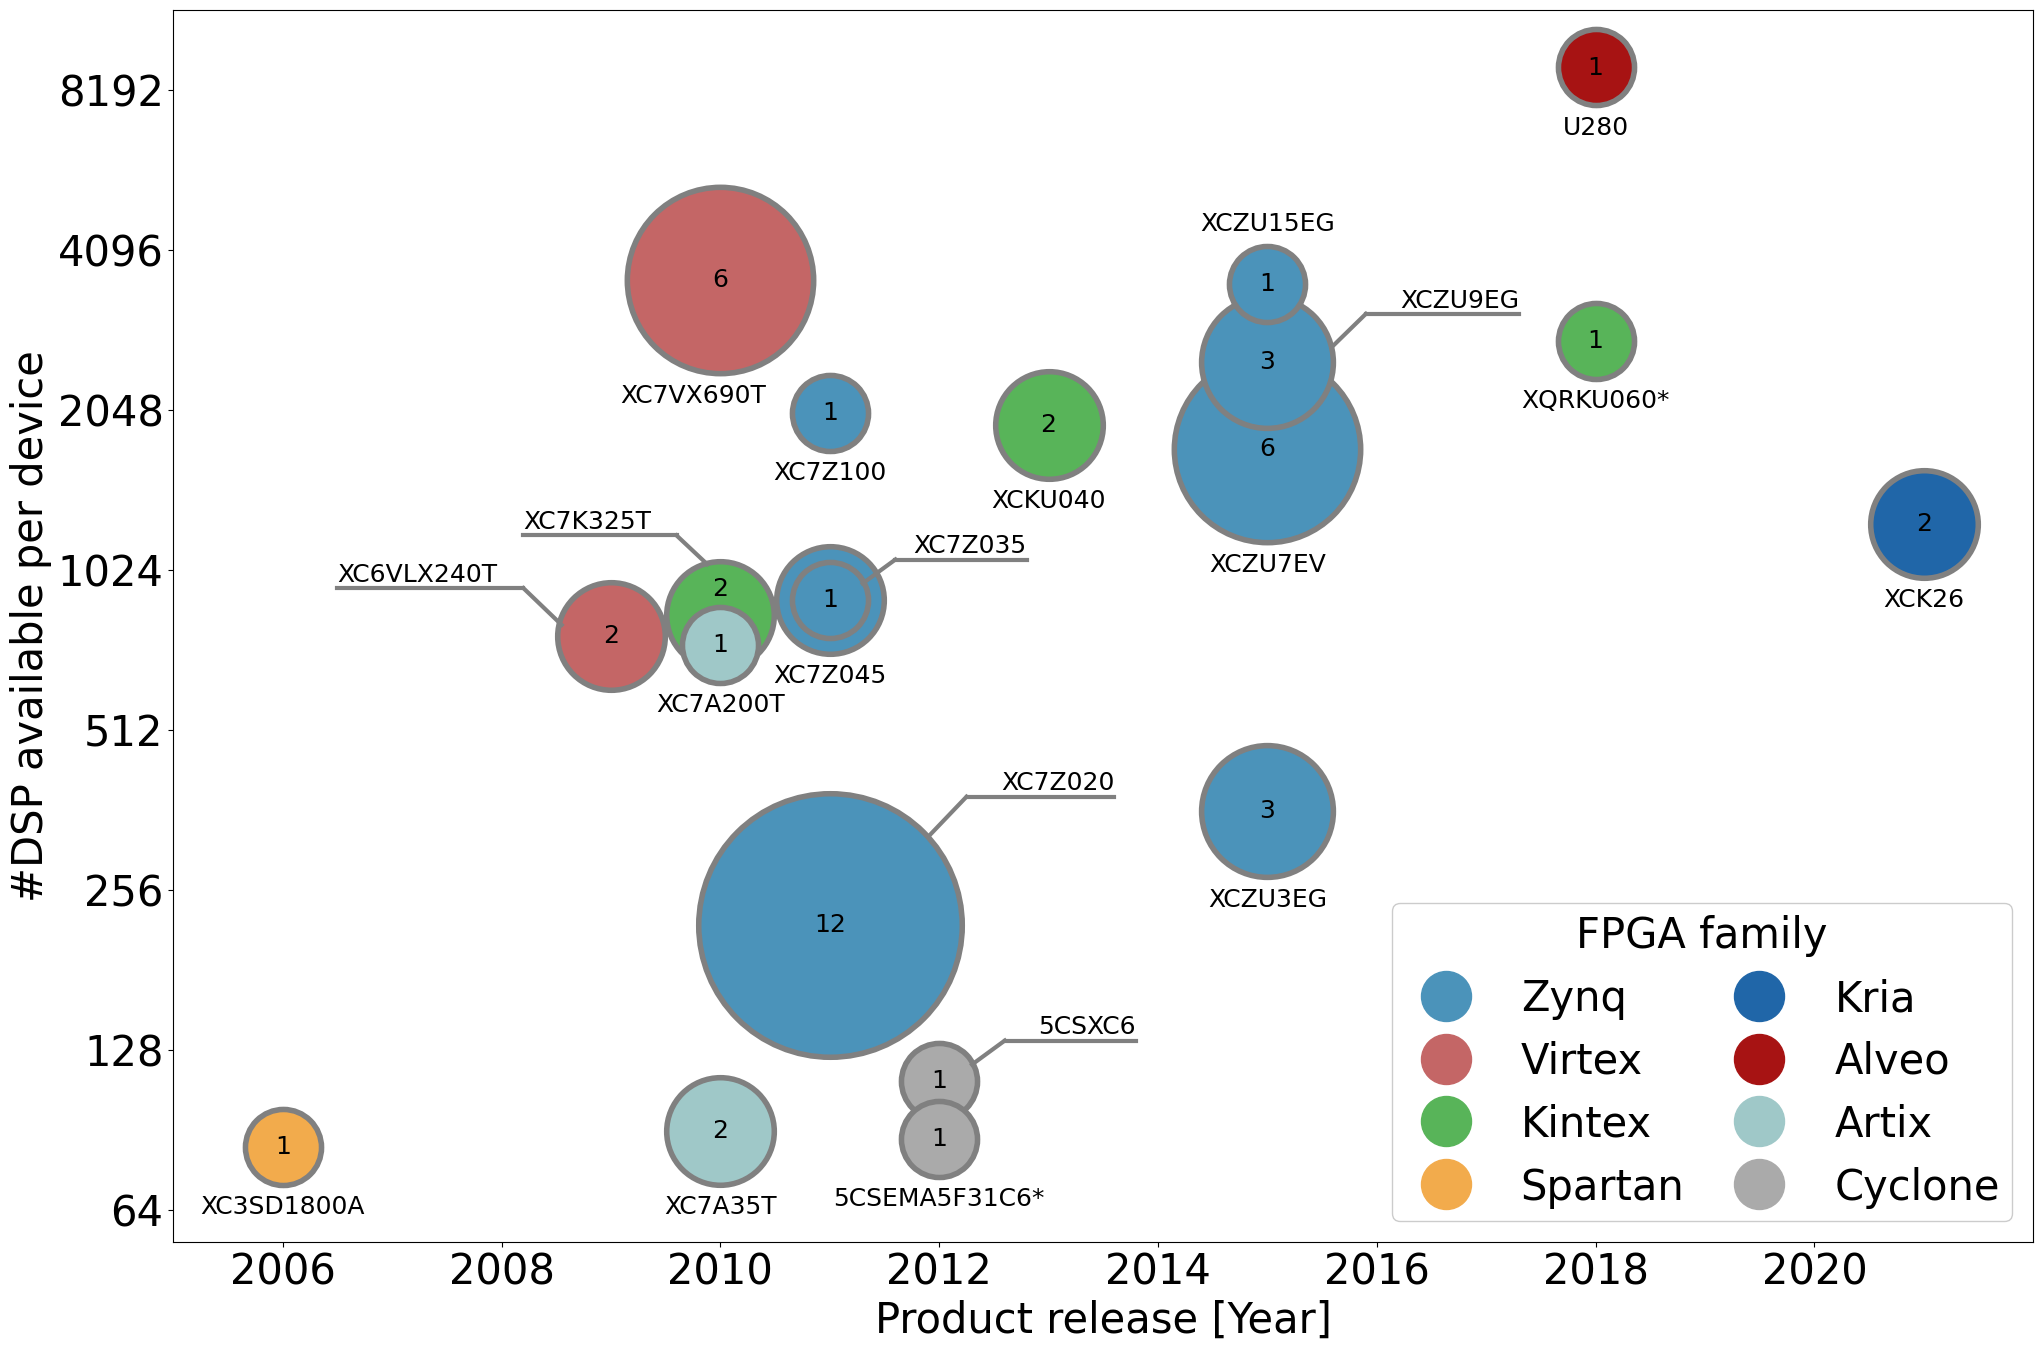

In [14]:
# Boolean parameter to add the quantity of each FPGA to the label
with_quantity = False
lbl_support_offset = 0 if with_quantity else 0.2

fcolors = {
    "Zynq":     plot_colors["blue_2"],
    "Virtex":   plot_colors["red_3"],
    "Kintex":   plot_colors["green_2"],
    "Virtex":   plot_colors["red_3"],
    "Spartan":  plot_colors["orange_2"],
    "Kria":     plot_colors["blue_1"],
    "Alveo":    plot_colors["red_1"],
    "Artix":    plot_colors["teal_3"],
    "Cyclone":  plot_colors["gray"],
}

plt.rcParams.update({'font.size': 30})

# Create a figure and a single axes using a more standard approach
fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(111)

# Offsets from the center for the labels depending on the circle size
label_y_offsets = {
    1: 0.3,
    2: 0.4,
    3: 0.48,
    6: 0.65,
}

for part_name, info in parts_info.items():
    x = info["year"]
    y = np.log2(info["DSP"])
    quantity = info["quantity"]
    # Add a star to the label for boards that do NOT appear in the table, we explain in the caption
    if part_name == "5CSEMA5F31C6" or part_name == "XQRKU060": 
        part_name = part_name + "*"
    label = (part_name + "(" + str(quantity) + ")") if with_quantity else part_name
    x_offset = 0
    y_offset = label_y_offsets.get(quantity, 0.25)  # default offset if quantity isn't in offsets

    ax.scatter(x, y, quantity*3000, ec="gray", lw=4, c=fcolors[info["family"]])

    if not with_quantity:
        # Add the label to the center of the circle except for overlapping circles:
        y_quant_offset = 0
        if part_name == "XC7K325T":
            y_quant_offset = 0.17
        elif part_name == "XC7Z045":
            # Skip this label, it overlaps with the "1" from "XC7Z035", instead add the quantity and the part_name label
            # label += "(" + str(quantity) + ")"
            quantity = ""
        ax.text(
            x,
            y + y_quant_offset,
            quantity,
            fontsize=18,
            ha="center",
            va="center",
        )

    if part_name == "XCZU15EG":
        y_offset = -0.45
    elif part_name == "XC7VX690T":
        x_offset = 0.25
    # elif part_name == "XC7Z045":
    #     x_offset = -0.15
    # Top right
    elif part_name == "5CSXC6" or part_name == "XC7Z035":
        support_labels(ax, [2 - lbl_support_offset, 0.25], [0.6, 0.25], [0.3, 0.1], label, [x, y])
        continue
    elif part_name == "XCZU9EG":
        support_labels(ax, [2.5 - lbl_support_offset, 0.3], [0.9, 0.3], [0.60, 0.1], label, [x, y])
        continue
    elif part_name == "XC7Z020":
        support_labels(ax, [2.8 - lbl_support_offset, 0.8], [1.25, 0.8], [0.9, 0.55], label, [x, y])
        continue
    # Top left
    elif part_name == "XC7K325T":
        support_labels(ax, [-2 + lbl_support_offset, 0.5], [-0.4, 0.5], [-0.12, 0.32], label, [x, y])
        continue
    elif part_name == "XC6VLX240T":
        support_labels(ax, [-2.7 + lbl_support_offset, 0.3], [-0.8, 0.3], [-0.45, 0.07], label, [x, y])
        continue

    ax.text(
        x - x_offset,
        y - y_offset,
        label,
        fontsize=18,
        ha="center",
        va="top",
        backgroundcolor="w"
    )


handles = []
for key, color in fcolors.items():
    handles.append(
        plt.Line2D(
            [0], [0],
            color=color,
            linewidth=0,
            linestyle='-',
            label=key,
            marker="o",
            markersize=36
        )
    )
fig.legend(
    title="FPGA family",
    handles=handles,
    loc='lower right',
    bbox_to_anchor=(0.9, 0.11),  # bottom-right, slightly above the axis
    framealpha=1,
    labelspacing=0.5,
    borderpad=0.3,
    handleheight=0.8,
    columnspacing=0.8,
    ncols=2
)

yt = [str(2**f) for f in range(6, 14)]
ax.set_yticks(range(6, 14), yt)
ax.set_ylim(5.8, 13.5)
ax.set_ylabel("#DSP available per device")

xt = np.arange(2006, 2022, 2)
ax.set_xticks(xt, xt)
ax.set_xlim(2005, 2022)
ax.set_xlabel("Product release [Year]")

fig.savefig(str(saveFigurePath), format=saveFormat, bbox_inches='tight')
plt.show()

### Quick statistics


In [ ]:
# Percent of boards that are not AMD, i.e., Intel Cyclone boards that start with "5CS"
total = sum([info["quantity"] for _, info in parts_info.items()])
intel = sum([info["quantity"] for part_name, info in parts_info.items() if part_name.startswith("5CS")])
print(f"Intel Cyclone boards: {intel} ({intel/total*100:.2f}%)")
# How many boards have more than 500 DSPs
high_dsp = sum([info["quantity"] for _, info in parts_info.items() if info["DSP"] > 500])
print(f"Boards with more than 500 DSPs: {high_dsp} ({high_dsp/total*100:.2f}%)")
# Percent Zynq family
zynq = sum([info["quantity"] for _, info in parts_info.items() if info["family"] == "Zynq"])
print(f"Zynq boards: {zynq} ({zynq/total*100:.2f}%)")

Intel Cyclone boards: 2 (3.92%)
Boards with more than 500 DSPs: 31 (60.78%)
Zynq boards: 29 (56.86%)
